# Trump Score - czyli kto za czym głosuje w senacie?
Michał Bień (132191)

grupa I2

wtorek 15:10-16:40

Dataset dostępny dzięki uprzejmości projektu five-thirty-eight, ich własna wizualizacja dostępna na stronie:

https://projects.fivethirtyeight.com/congress-trump-score/

Z uwagi na ich naturę dane są stricte obserwacyjne. Dataset zawiera zbiór danych dla całej populacji (Izba Reprezentantów i Senat). Dane zostają oczyszczone jedynie z tych oberwacji, dla których wartość TrumpScore jest nieznana

W badaniu sprawdzimy, czy prezydent ma poparcie w Rządzie USA

Ładujemy dane (na dzień 9.05) do dataframe i podglądamy:

In [1]:
df <- read.csv(url("https://projects.fivethirtyeight.com/congress-tracker-data/csv/averages.csv"), header=TRUE)
head(df)

chamber,bioguide,last_name,state,district,party,votes,agree_pct,predicted_agree,net_trump_vote
house,A000055,Aderholt,AL,4,Republican,72,0.9861111,0.9335537,63.0
house,A000367,Amash,MI,3,Republican,72,0.5555556,0.8295785,9.4
house,A000369,Amodei,NV,2,Republican,70,0.9857143,0.8598324,12.3
house,A000370,Adams,NC,12,Democrat,69,0.1449275,0.1673907,-40.0
house,A000371,Aguilar,CA,31,Democrat,71,0.2112676,0.2687628,-21.1
house,A000372,Allen,GA,12,Republican,72,0.9722222,0.8923807,16.2


mamy więc etykiety określające: izbę, nazwisko, stan i dystrykt reprezentowany, partię, liczbę głosowań w których wzięto udział, oraz procent zgody z Donaldem Trumpem w tych głosowaniach. Usuńmy niepotrzebne nam kolumny i podpiszmy je po naszemu

In [2]:
data <- df[c('chamber', 'party', 'agree_pct')]
colnames(data)<-c('izba', 'partia', 'trump')
data <- data[!is.na(data$trump),]
summary(data)

     izba             partia        trump       
 house :440   Democrat   :244   Min.   :0.0000  
 senate:104   Independent:  2   1st Qu.:0.2000  
              Republican :298   Median :0.8518  
                                Mean   :0.6074  
                                3rd Qu.:0.9571  
                                Max.   :1.0000  

Znajdźmy wariancję dla trumpscore. Jest on głównym interesującym nas parametrem, jest typu ilorazowego - określa procent głosów oddanych za Trumpem. Rozkład cechy w populacji nie jest znany

In [3]:
trump <- data$trump
var(trump)

[1] 0.1354963

Dane wyglądają teraz dużo lepiej. Pora dowiedzieć się co nieco o preferencjach głosujących. Do stworzenia szeregu rozdzielczego posłużymy się trumpscore, o szerokości przedziału klasowego 0.05

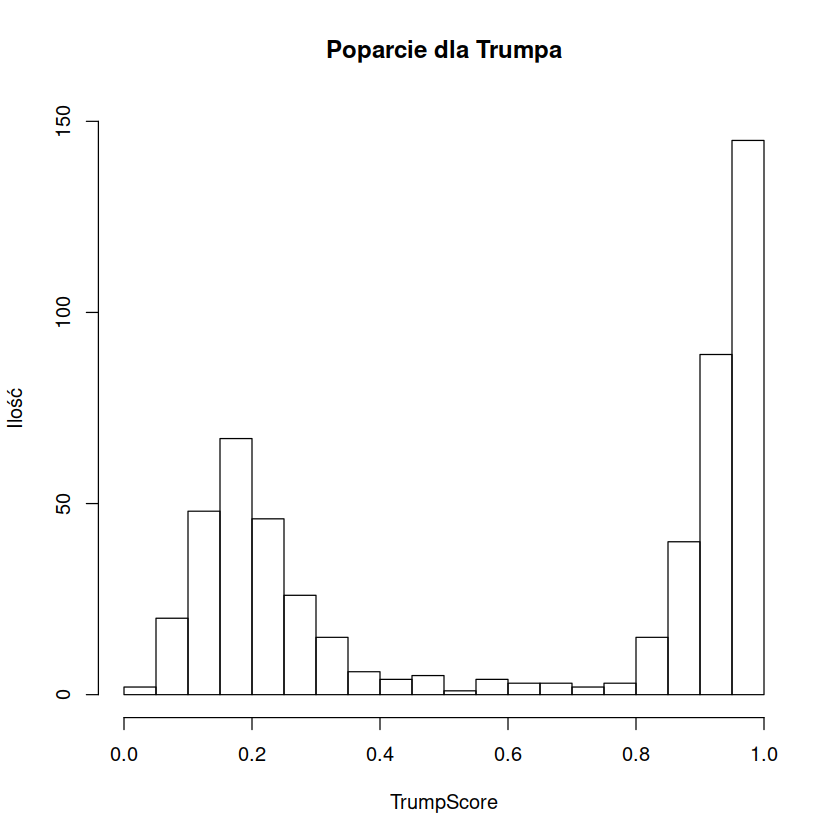

In [4]:
hist(data$trump, ylim=range(0,150), breaks = seq(0, 1, by=0.05), main='Poparcie dla Trumpa', xlab='TrumpScore', ylab='Ilość')

Jak widać - niezdecydowanych jest niewielu. Sprawdźmy jak sprawa wygląda w partiach:

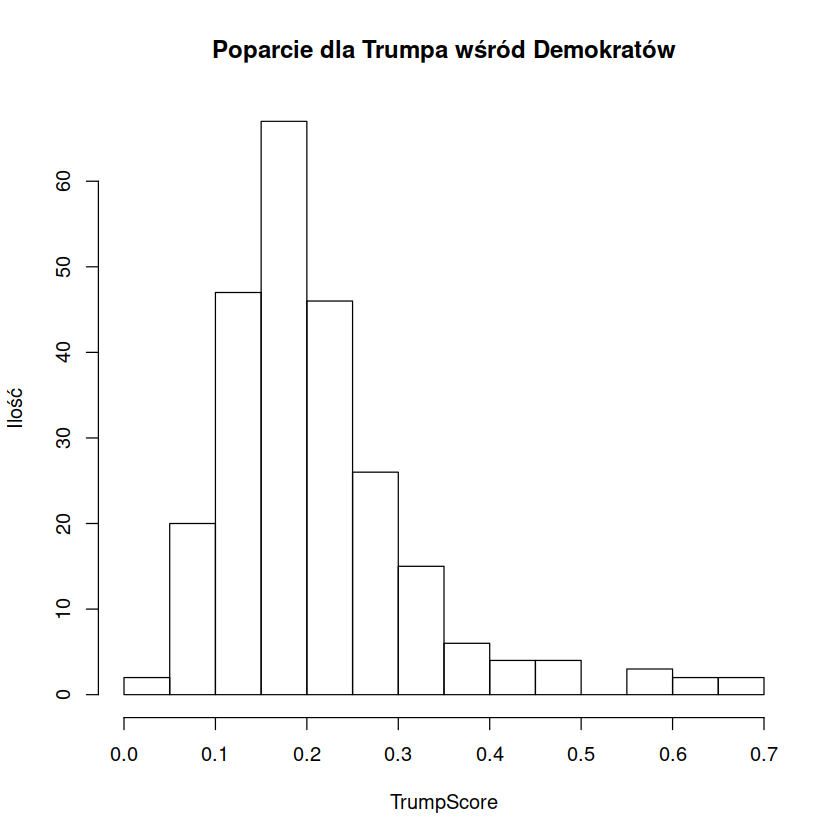

In [5]:
demokraci <- data[data$partia=='Democrat',]
hist(demokraci$trump, breaks = seq(0, 0.7, by=0.05), main='Poparcie dla Trumpa wśród Demokratów', xlab='TrumpScore', ylab='Ilość')

Większość demokratów nie zgadza się z Trumpem ale akceptują niektóre jego akty, jak wskazuje kilkuosobowa liczebność przy współczynnikach ok 0.6. Ilość całkowicie niezgadzających się jest bardzo niska. Skośność jest oczywiście prawostronna.

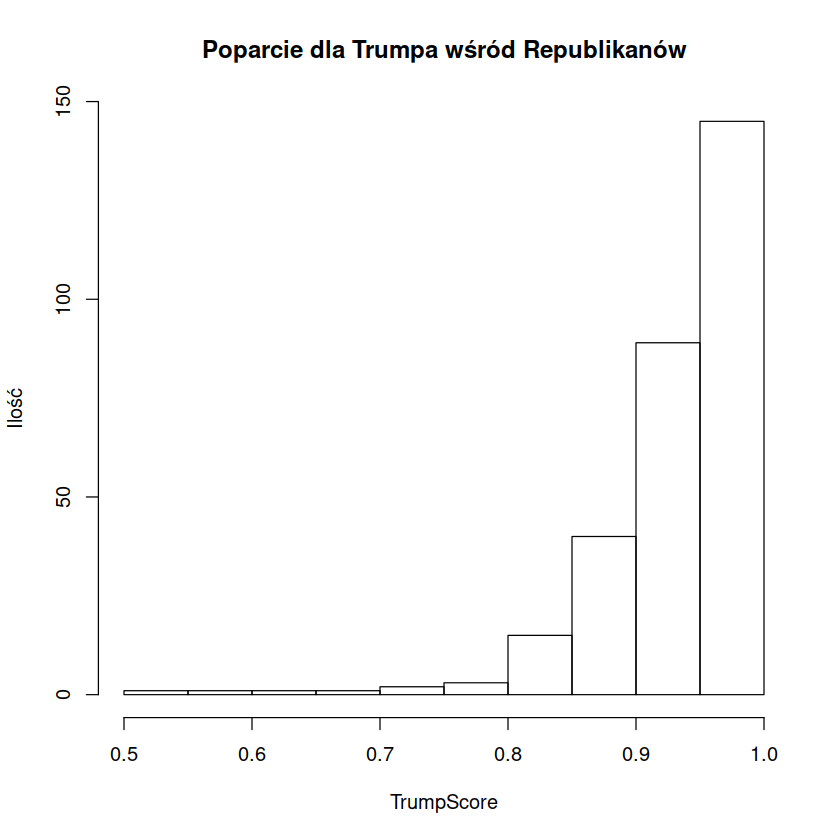

In [6]:
republikanie <- data[data$partia=='Republican',]
hist(republikanie$trump, breaks = seq(0.5, 1, by=0.05), main='Poparcie dla Trumpa wśród Republikanów', xlab='TrumpScore', ylab='Ilość')

Republikanie są bardziej zdyscyplinowani - niemal jednogłośnie wtórują swojemu prezydentowi (skośność bezwzględna cechy jest większa niż dla demokratów - i jest oczywiście lewostronna)

Z tych wykresów, a także summary powyżej można wywnioskować duży rozrzut w danych, zobaczmy więc jak wygląda boxplot, aby sprawdzić, czy jakieś błędy nie zaburzają naszych rozważań:

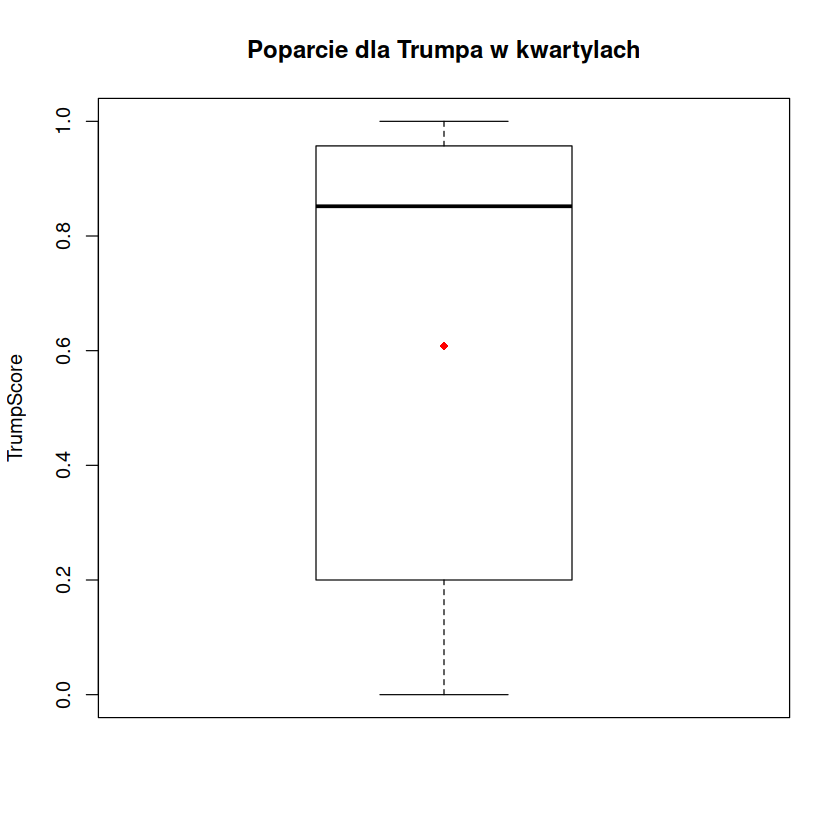

In [7]:
boxplot(data$trump, ylab='TrumpScore', main='Poparcie dla Trumpa w kwartylach')
points(mean(data$trump), col='red', pch=18)

Zauważmy, że chociaż mediana ma bardzo dużą wartość, to 1. kwartyl nie pozwala na ufność w jej wskazania. Wygląda na to że nie ma możliwości mówić o jakichkolwiek outlierach, kiedy mamy TAKI rozstęp międzykwartylowy! Dla pewności rzućmy okiem, jaka jest dokładnie jego wartość:

In [8]:
IQR(data$trump)

[1] 0.7571429

Koniec badań dla całej populacji. Wyznaczmy próbę do testu, niech będzie to 10% izby reprezentantów i 10% senatu:

In [25]:
senat <- data[data$izba=='senate',]
dom <- data[data$izba=='house',]

set.seed(12) #aby próba losowa była przewidywalna
pr_senat <- senat[sample(seq_len(nrow(senat)), size=nrow(senat)*0.1),]
pr_dom <- dom[sample(seq_len(nrow(dom)), size=nrow(dom)*0.1),]
proba <- rbind(pr_senat, pr_dom)
nrow(proba)

[1] 54

Rzućmy jeszcze szybko okiem na statystykę opisową próbki:

In [11]:
summary(proba)

     izba            partia       trump       
 house :44   Democrat   :26   Min.   :0.0000  
 senate:10   Independent: 0   1st Qu.:0.1979  
             Republican :28   Median :0.7153  
                              Mean   :0.5690  
                              3rd Qu.:0.9409  
                              Max.   :1.0000  

Świetnie, mamy próbę na 54 członkach Izby Reprezentantów i Senatu, przejdźmy do testów:

sprawdzimy czy członkowie parlamenty USA są średnio za Trumpem (czyli czy ich TrumpScore jest większy od 0.5)

#### H0: p<=0.5
#### H1: p>0.5

Nie znamy rozkładu cech, ale mając próbę o ponad 30 obserwacjach możemy skorzystać z Centralnego Twierdzenia Granicznego, a tym samym przeprowadzić test Z

Test jest prawostronny. Przeprowadźmy nasz test na poziomie ufności 95% Wyznaczmy z krytyczne i przedział krytyczny.

In [27]:
alfa <- 0.95
zkr <- -qnorm(1-alfa, 0, 1)
zkr

[1] 1.644854

A więc przedział krytyczny ckr = (1.64485, nieskończoności)

Wyznaczamy statystkę testową - nie znamy niestety ani średniej ani wariancji dla populacji (a przynajmniej tak udajemy)

In [28]:
p <- 0.5
odchyl <- sd(proba$trump)
srednia <- mean(proba$trump)
z <- (srednia - p)/odchyl*sqrt(nrow(proba))
z

[1] 2.37029

Wyznaczona statystyka testowa mieści się w przedziale krytycznym. Wobec tego odrzucamy hipotezę zerową, przyjmując alternatywną: Trump ma w rządzie USA poparcie! Nie popełniliśmy żadnego błędu, jako że prawdziwa wartość statystyki wynosi ok 0.6 (została odczytana na początku). Wydaje się, że taki wynik jest efektem niemal całkowitego poparcia wśród Republikanów, oraz niezdecydowania wśród Demokratów. Faktem jest też, iż Demokratów jest w rządzie nieznacznie mniej.

Dziękuję za uwagę, ewentualne pytania co do przyjętych założeń proszę kierować na mój adres email